# Calibration of Epidemic Models to Data using Approximate Bayesian Computation

In this tutorial, we will explore how to calibrate epidemic models to data using the ***epydemix*** package.

Let's start importing the necessary libraries:

In [1]:
from scipy import stats 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
from epydemix.model import EpiModel, simulate
from epydemix.visualization import plot_error_distribution, plot_selected_quantiles, plot_posterior, plot_posterior_2d
from epydemix.calibration import calibrate, rmse
from epydemix.utils import compute_simulation_dates

## Model Calibration 

***Epydemix*** currently supports 3 calibration methods: 


1. ***ABC-SMC Calibration***: this is the most sophisticated supported method which implements the Approximate Bayesian Computation Sequential Monte Carlo (ABC-SMC) algorithm. In general, this method allows to achieve more accurate results, but may be more computationally expensive.

2. ***ABC Rejection***: this method implements the simple Approximate Bayesian Computation Rejection algorithm

3. ***Top X% Simulations***: this method implements a variation of the ABC rejection algorithm, where, instead of defining a tolerance and accepting/rejecting based on this, a total budget of simulations is run and the final set of accepted particles is the top X%, regardless of any tolerance threshold. This guarantees results in an allocated amount of time, but it is less accurate and robust than the other two methods. For this reason, we suggest to use this method mostly for exploratory purposes or for recurrent tasks that needs a fixed elapsing time.


First, we import epidemiological data on which we want to calibrate the model. In particular we start considering the dataset ```data_I.csv```, where the quantity of interest is the number of individuals which are infected at each time step (i.e., prevalence) for some disease in Indonesia.

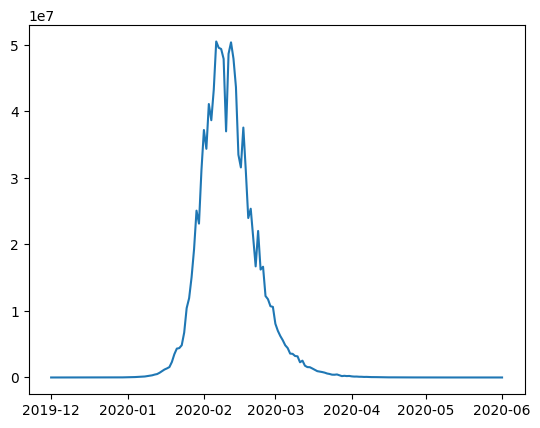

In [2]:
data = pd.read_csv('./data/data_I.csv')
data["date"] = pd.to_datetime(data["date"])

plt.plot(data["date"], data["I"], label="I")

Next, we create an SIR model using ***epydemix*** and we set the right population data:

In [3]:
model = EpiModel(predefined_model='SIR')
model.import_epydemix_population(population_name="Indonesia", 
                                 population_data_path="../epydemix_data/")

print(model)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, rate: transmission_rate
    Infected -> Recovered, rate: recovery_rate
Parameters: 2
  Model parameters:
    transmission_rate: 0.3
    recovery_rate: 0.1
Population: Indonesia
  Population size: 282353643 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



 Before running the calibration, we need to setup arguments for the simulations, including simulation dates and initial conditions:

In [4]:
# initial conditions (we assume fully S population except for one infected individual in each age group)
initial_conditions = {"Susceptible": model.population.Nk - np.ones(len(model.population.Nk)), 
                      "Infected": np.ones(len(model.population.Nk)),
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates = compute_simulation_dates(start_date=data.date.values[0], 
                                            end_date=data.date.values[-1], steps="daily")

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "simulation_dates": simulation_dates}

Finally, we are left with defining the prior distributions for the free parameters. We assume a uniform prior distribution for both the transmission and recovery rate:

In [5]:
priors = {"transmission_rate": stats.uniform(0.015, 0.025), 
          "recovery_rate": stats.uniform(0.15, 0.25)}

We can now run the calibration. We will apply all three methods and then we will compare results. 

The ```calibration``` function takes as input a simulation function that as only requirement need to return a dictionary with a key 'data', which is the output quantity which will be used to compute errors and perform particle selection. 

Thanks to this feature, the input of the calibration function does not have to be necessarily linked to ***epydemix*** but it can be any function that meets this minimal requirement. In this way, you can calibrate also external models using the same pipeline used for epydemix models.

Let's start running the ABC-SMC function with 5 generations by 100 accepted particles each and the Root Mean Squared Error as distance function: 

In [6]:
# This function is needed as wrapper around simulate 
# to tell the calibration function which is the output
# quantity to compare with the data
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    results.update({"data": results["Infected_total"]})
    return results

start_time = time.time()
results_abc_smc = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": data["I"].values}, 
                    num_particles=100, 
                    max_generations=5, 
                    distance_function=rmse)
end_time = time.time()  
print("ABC-SMC - Elapsed time: ", np.round(end_time - start_time, 2), "seconds")

Generation 1: Tolerance = inf, Accepted Particles = 100/100, Time = 00:00:09, ESS = 100.0
Generation 2: Tolerance = 14604390.01536294, Accepted Particles = 100/204, Time = 00:00:15, ESS = 87.03426018436716
Generation 3: Tolerance = 12681188.054883732, Accepted Particles = 100/272, Time = 00:00:18, ESS = 96.75847602197565
Generation 4: Tolerance = 7436058.309407802, Accepted Particles = 100/194, Time = 00:00:14, ESS = 91.98321024862518
Generation 5: Tolerance = 5590469.620449503, Accepted Particles = 100/266, Time = 00:00:19, ESS = 94.48992996058995
ABC-SMC - Elapsed time:  78.1 seconds


Next we run the ABC rejection algorithm, setting a tolerance based on the that of the ABC-SMC algorithm in the last generations:

In [13]:
start_time = time.time()
results_abc_rejection = calibrate(strategy="abc_rejection", 
                                  simulation_function=simulate_wrapper, 
                                  priors=priors, 
                                  parameters=parameters, 
                                  observed_data={"data": data["I"].values}, 
                                  num_particles=100, 
                                  tolerance=5500000, 
                                  distance_function=rmse)
end_time = time.time()  
print("ABC Rejection - Elapsed time: ", np.round(end_time - start_time, 2), "seconds")

ABC Rejection - Elapsed time:  100.45 seconds


Finally, we run the Top X% Simulations strategy, giving a total simulation budget similar to the total simulations run by the ABC-SMC algorithm and taking the top 10%, in order to have 100 simulations accepted:

In [8]:
start_time = time.time()
results_top_perc = calibrate(strategy="top_perc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": data["I"].values}, 
                    Nsim=1000,
                    top_perc=0.1,
                    distance_function=rmse)
end_time = time.time()  
print("Top X% - Elapsed time: ", np.round(end_time - start_time, 2), "seconds")

Top X% - Elapsed time:  55.9 seconds


Finally, we compare the results from the three calibrations

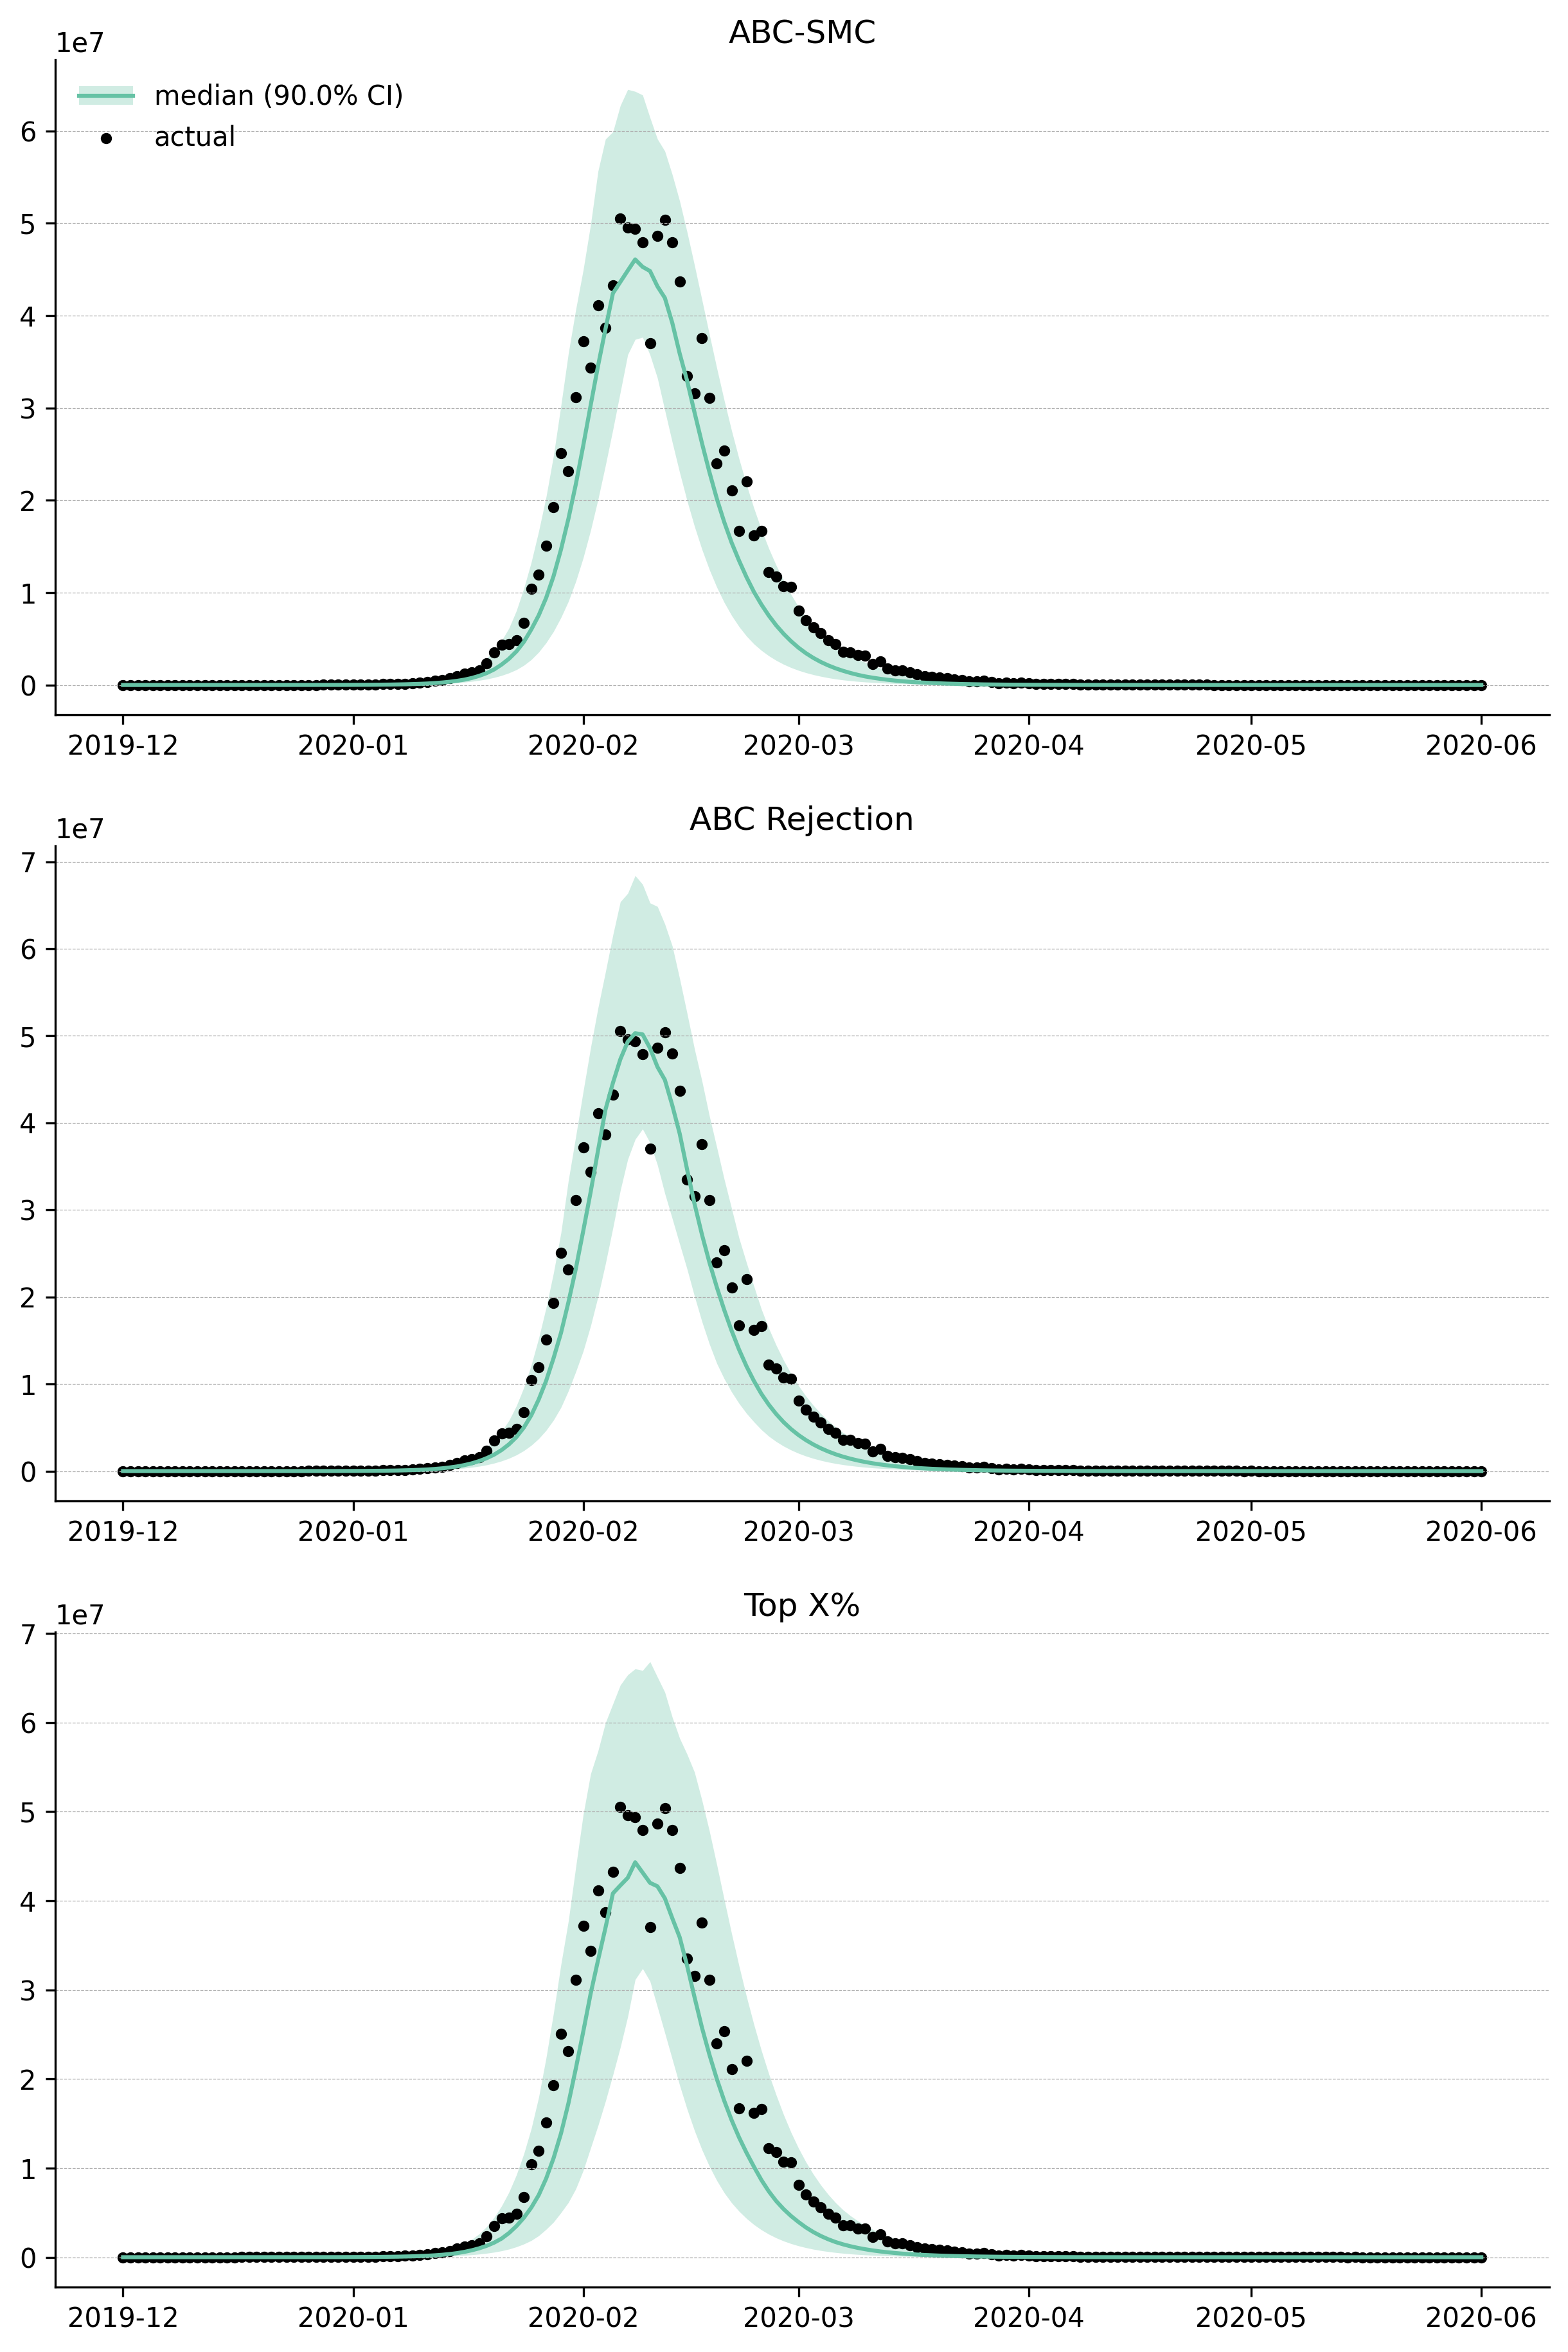

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15), dpi=300)

plot_selected_quantiles(results_abc_smc, ax=axes[0], title="ABC-SMC")   
plot_selected_quantiles(results_abc_rejection, ax=axes[1], show_legend=False, title="ABC Rejection")
plot_selected_quantiles(results_top_perc, ax=axes[2], show_legend=False, title="Top X%")

/Users/nicolo/Desktop/epydemix/epydemix/visualization/plotting.py:260: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)
/Users/nicolo/Desktop/epydemix/epydemix/visualization/plotting.py:260: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)
/Users/nicolo/Desktop/epydemix/epydemix/visualization/plotting.py:260: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


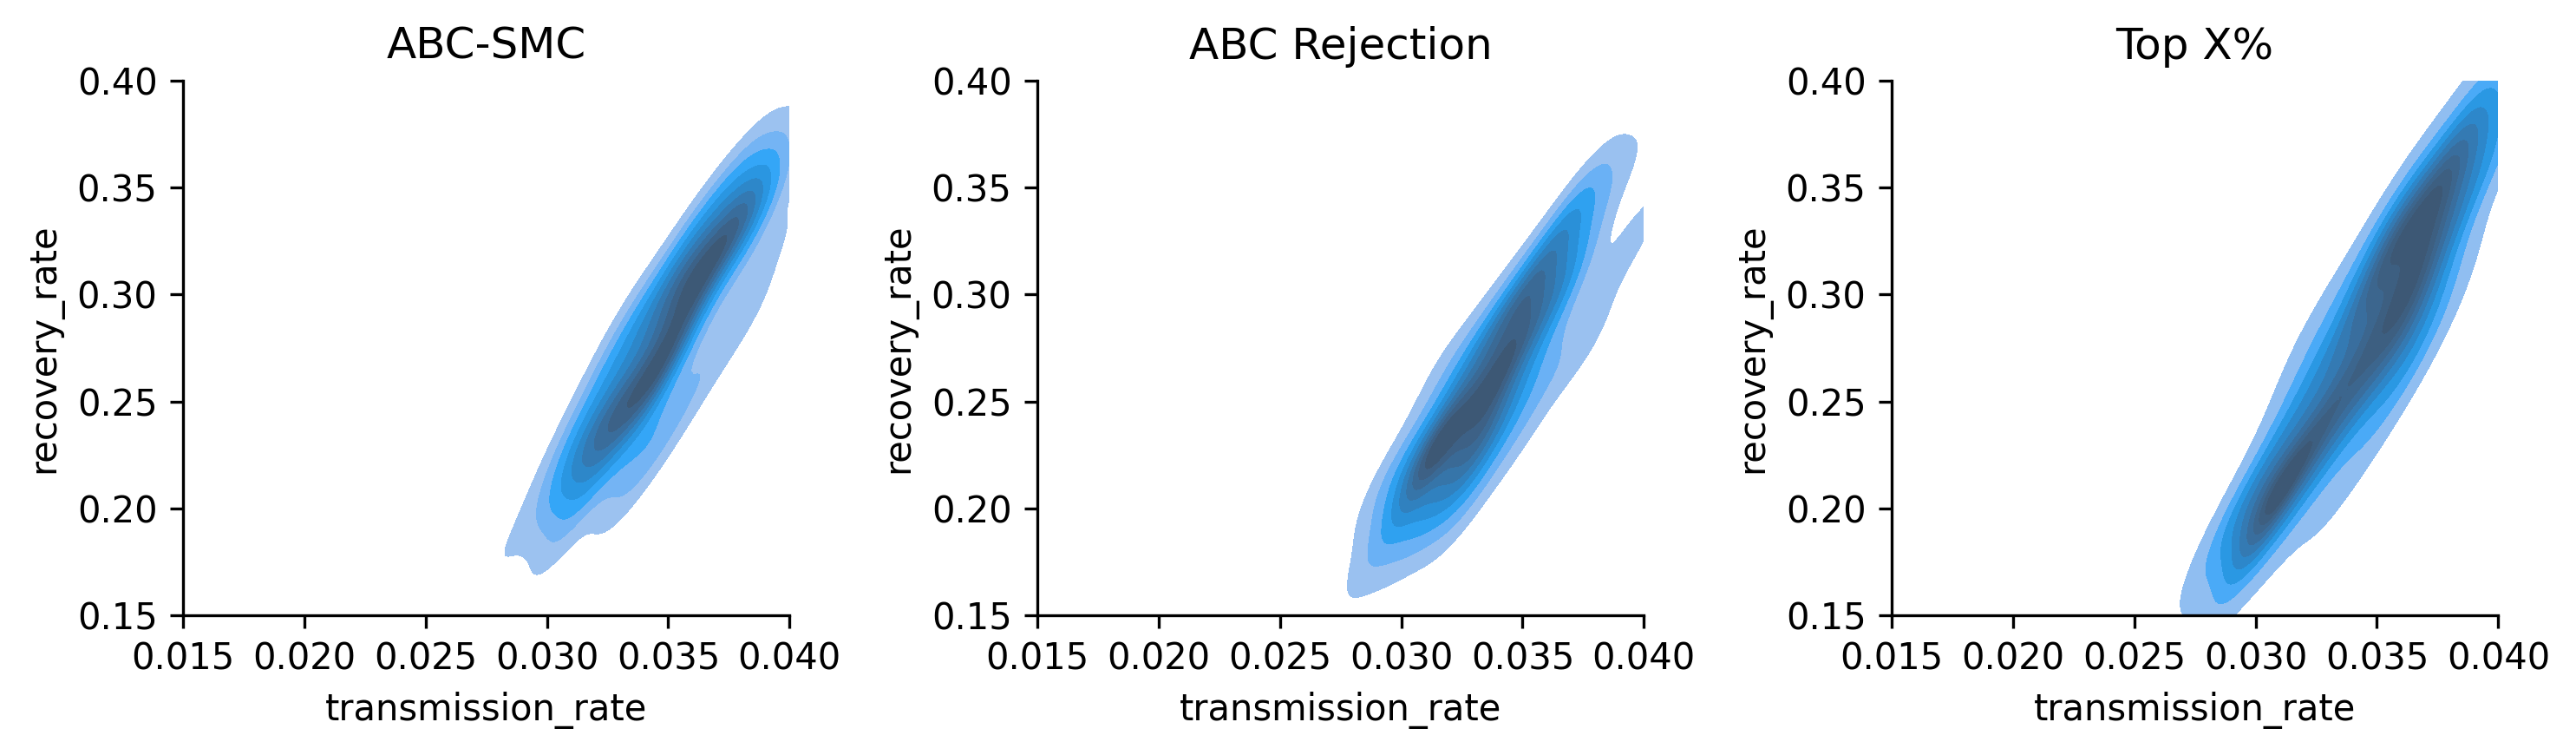

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
plot_posterior_2d(results_abc_smc, "transmission_rate", "recovery_rate", ax=axes[0], kind="kde", title="ABC-SMC", prior_range=True)
plot_posterior_2d(results_abc_rejection, "transmission_rate", "recovery_rate", ax=axes[1], kind="kde", title="ABC Rejection", prior_range=True)
plot_posterior_2d(results_top_perc, "transmission_rate", "recovery_rate", ax=axes[2], kind="kde", title="Top X%", prior_range=True)

plt.tight_layout()

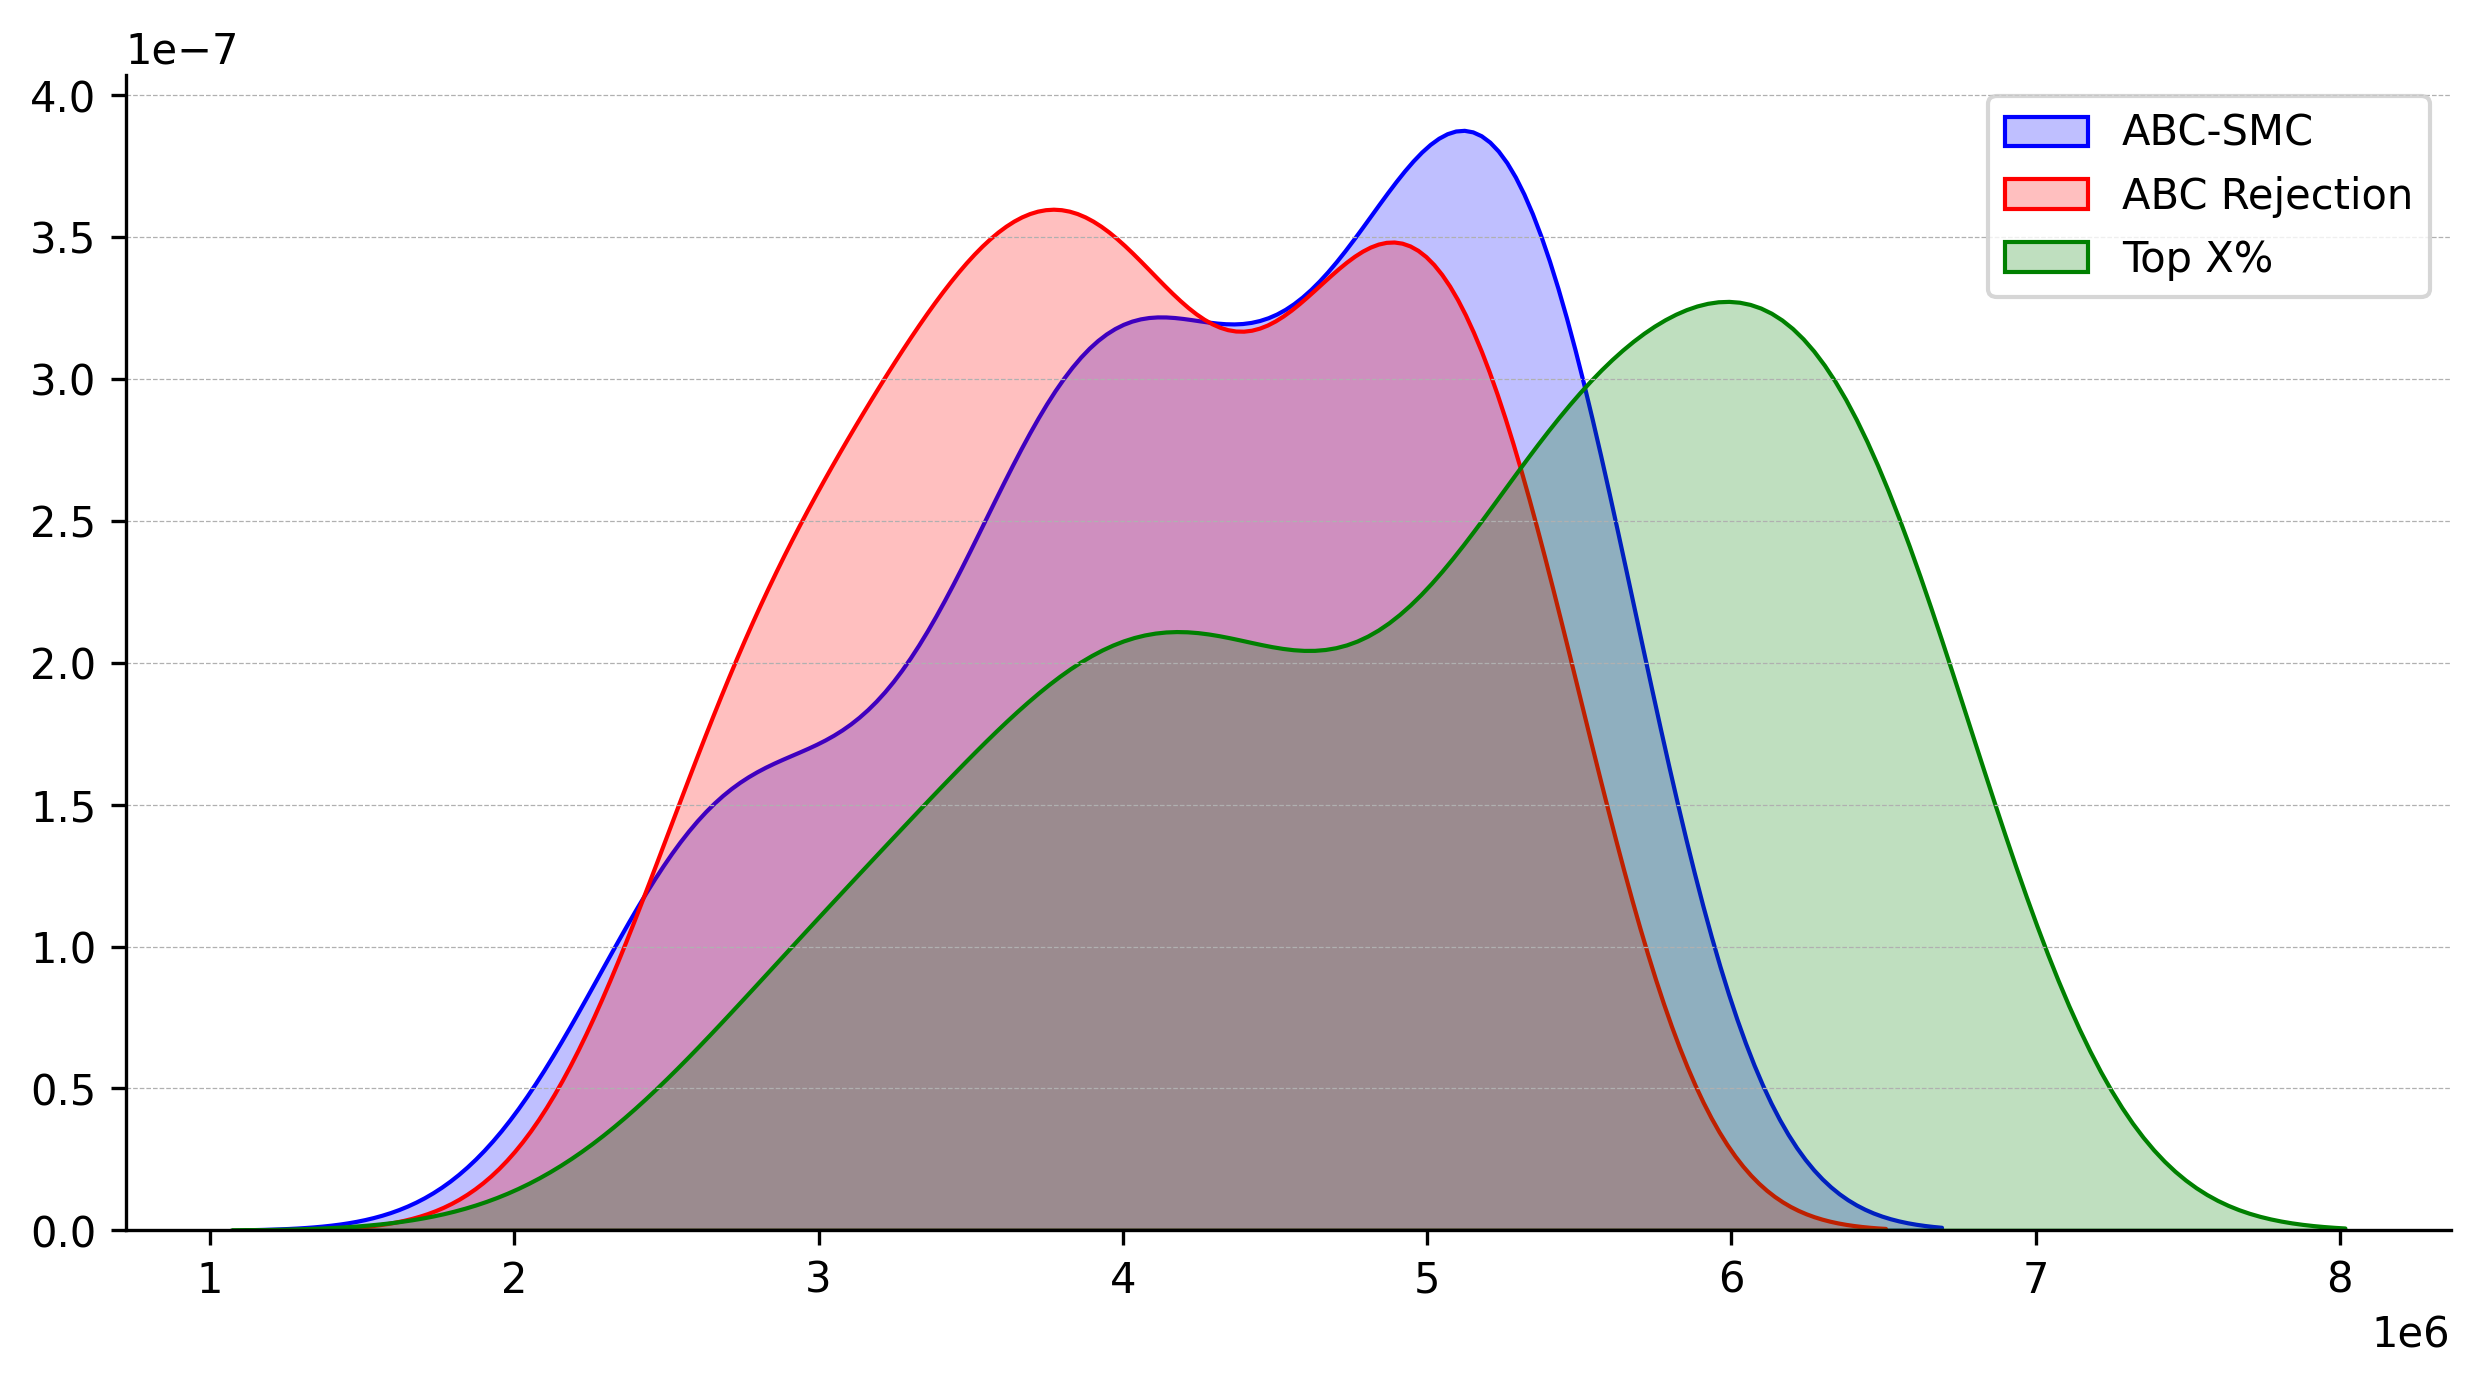

In [26]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
plot_error_distribution(results_abc_smc, ax=ax, kind="kde", color="blue", label="ABC-SMC")
plot_error_distribution(results_abc_rejection, ax=ax, kind="kde", color="red", label="ABC Rejection")
plot_error_distribution(results_top_perc, ax=ax, kind="kde", color="green", label="Top X%")
ax.legend()